In [1]:
from cmath import nan
from suite2p.extraction import dcnv
import numpy as np
from skimage.io import imread
from skimage.measure import block_reduce
import os
from matplotlib import pyplot as plt
from matplotlib import cm
import pickle
import json
import scipy.io as scio
import pickle
from scipy import signal
import scipy
from pathlib import Path
from sklearn.linear_model import LinearRegression
from scipy.ndimage import median_filter

In [2]:
# Absolute path to the JSON file
file_path = Path(r'C:/Users/Conor/2Psinapod/2Psinapod/config_widefield.json')

# Load JSON file
with file_path.open('r') as f:
    config = json.load(f)

In [3]:
BASE_PATH = config['RecordingFolder'] # folder with all of the files required to process recording. 
TIFF_PATH = config['TIFF']
CSV_PATH = config['Triggers'] # name of CSV (assumed to be in the folder given in line above) with the trigger voltages over the recording
CONDITIONS_PATH = config['Conditions'] # name of the CSV (assumed to be in folder given two lines above) with the condition types of each trial (freq, intensity, etc)
TIFF = BASE_PATH + TIFF_PATH

STIMULUS_FRAMERATE = config['TriggerFR'] # framerate of the trigger file
TRIGGER_DELAY_IN_MS = config['TriggerDelay'] # delay between TDT sending a trigger and the stimulus actually happening
RECORDING_FRAMERATE = config['RecordingFR'] # framerate of the fluorescence recording
EPOCH_START_IN_MS = config['EpochStart'] # time to include before trial onset for each epoch
EPOCH_END_IN_MS = config['EpochEnd'] # time to include after trial onset for each epoch
NO_BASELINE_FRAMES = config['BaselineFrames']
ZSCORE_THRESHOLD = config['ZscoreThreshold']
START = config['ResponseStart']
STOP = config['ResponseStop']

In [4]:
def get_onset_frames(stimulus):
    # find the max voltage (this will be the value in the vector when the trigger was sent)
    max_voltage = max(stimulus, key=lambda x:x[1])
    max_voltage = max_voltage[1]

    onset_times = [] # empty list to append our onset frames into
    time_list_index = 0 # counter to keep track of our index in the onset_times list

    # for each frame in the stimulus file
    for stimulus_idx in range(len(stimulus)):
        (time,voltage) = stimulus[stimulus_idx] # unpack the voltage at that timepoint

        if voltage.round() == max_voltage.round(): # if the voltage was our trigger voltage
            if time_list_index == 0: # and if we're at the first index (so there's no previous index to compare with)
                trigger_time_in_sec = time/1000 + TRIGGER_DELAY_IN_MS/1000
                onset_times.append(trigger_time_in_sec) # add the time as an onset time in SECONDS
                time_list_index += 1

            # if we're not at index zero, we need to compare this voltage with the previous saved onset voltage
            # otherwise we save a bunch of voltages as separate triggers because they all match the max voltage
            # but we just want one timepoint per trigger
            elif time/1000 -  onset_times[time_list_index - 1] > 1: 
                trigger_time_in_sec = time/1000 + TRIGGER_DELAY_IN_MS/1000
                onset_times.append(trigger_time_in_sec) # want it in second not millisecond
                time_list_index += 1

    # get the onset times in terms of frames of our fluorescence trace
    onset_frames_at_recording_fr = np.multiply(onset_times,RECORDING_FRAMERATE) # s * f/s = f

    #Remove first three triggers, corresponding to start at frame zero, 
    onset_frames_at_recording_fr = onset_frames_at_recording_fr[3:]

    return onset_frames_at_recording_fr

In [5]:


'''
Load the tiff stack of the recording as a single 3D array and downsample it from 512x512 to 256x256 (if recording is larger than 512x512, change block size).   
Note: The tiff stack must be the only thing in the folder.  It will try to load other items into the array.
@Param: Name of folder (paste path into FILESTOLOAD section)
Return: (N_frames x N_pixels x N_pixels) numpy array.
'''
def load_recording(TIFF):

        video = []
        images = [img for img in os.listdir(TIFF)]

        for img in images:
                im = imread(TIFF+img)
                downsamp_img = block_reduce(im,block_size=(2,2),func=np.mean)
                video.append(downsamp_img)
        video = np.array(video)

        return video

In [6]:
def regress_out_global_flucts(video):
    average_intensity = np.mean(video, axis=(1, 2))

    X = np.reshape(average_intensity,(-1,1))

    nFrames, Xpixel, Ypixel = video.shape
    y = video.reshape((nFrames, Xpixel * Ypixel))

    reg = LinearRegression().fit(X, y)

    predict = reg.predict(X)

    corrected = y - predict

    corrected_video = corrected.reshape(video.shape[0],video.shape[1],video.shape[2])

    return corrected_video

In [7]:
def get_pixel_baseline(pixel_trace,onset_frames):
    
    baselines = np.empty(len(onset_frames)) 

    for i, idx in enumerate(onset_frames):
        start_idx = max(0, idx - 5)
        end_idx = idx  # Don't Include the value at the onset frame.
        baseline_frames = pixel_trace[int(start_idx): int(end_idx)]

        baselines[i] = np.mean(baseline_frames)

    pixel_baseline = np.mean(baselines)
    
    return pixel_baseline

In [8]:
# convert to delta f / f0 

def convert_deltaF_F0(video,onset_frames):

    deltaF_F0_converted = np.zeros_like(video) 

    # For each pixel, use the onset frames to get all the pre-stimulus baseline values - the mean of this is F0
    for i in range(len(video[0,:,0])):
        for j in range(len(video[0,0,:])):

            trace = np.array(video[:,i,j])

            pixel_baseline = get_pixel_baseline(trace,onset_frames)

            deltaF_F0 = ((trace - pixel_baseline)/pixel_baseline)

            deltaF_F0_converted[:,i,j] = deltaF_F0
    
    return deltaF_F0_converted

In [9]:
def epoch_trials(video,onset_frames):

        # Get length of trial in seconds
        trial_length_in_ms = EPOCH_END_IN_MS - EPOCH_START_IN_MS # this gives us length in ms
        trial_length_in_sec = trial_length_in_ms/1000 # now we have it in second

        # Convert this to length in frames
        trial_length_in_frames = int(trial_length_in_sec * RECORDING_FRAMERATE) # s * f/s = f

        # Initialize an array to store the epoched traces
        # nTrials x nFrames x nPixels x nPixels

        epoched_pixels = np.zeros((len(onset_frames),(trial_length_in_frames), len(video[0,:,0]), len(video[0,0,:])))

        #Start filling the empty matrix:
        # Loop through the onset frames
        for onset in range(len(onset_frames)-1):

                #Get the trial starting and ending frames
                trial_starting_frame = np.round(onset_frames[onset]) + (EPOCH_START_IN_MS/1000*RECORDING_FRAMERATE)
                trial_ending_frame = np.round(onset_frames[onset]) + (EPOCH_END_IN_MS/1000*RECORDING_FRAMERATE)


                #Grab this range of frames from the recording and store in epoched matrix
                epoch = video[int(trial_starting_frame):int(trial_ending_frame),:,:]
                epoched_pixels[onset,:,:] = epoch

        return epoched_pixels

In [10]:
'''
Normalize each trial to it's local pre-stimulus baseline by subtracting the mean of the pre-stim from each timepoint in the trial. 
@Param epoched pixels =  N_trials x N_frames x N_pixels x N_pixels array.
@param n_baseline_frames = The number of pre-stimulus baseline frames to use in the normalization. 
@Returns:  Ntrials x N_frames x N_pixels x N_pixels array of baseline adjusted trials. e.g. [0,:,0,0] is the normalized trace of the 
first trial at pixel 0,0. 
'''

def baseline_adjust_pixels(epoched_pixels):
        # Create an empty array to store the baseline adjusted trials in. Same shape as epoched pixels.
        baseline_adjusted_epoched = np.empty(shape=epoched_pixels.shape)

        # Iterate through the trials (i) and each x any y pixel coordinate (j and K)
        for i in range(len(epoched_pixels)):
                for j in range(len(epoched_pixels[0][0])):
                        for k in range(len(epoched_pixels[0][0])):

                                # Extract the specific trial to be normalized
                                test_trace = epoched_pixels[i,:,j,k]
                                # compute the average of the number of baseline frames
                                baseline_average = np.average(test_trace[0:NO_BASELINE_FRAMES])
                                # Subtract the baseline frames from the test trace 
                                normalized_trace = np.subtract(test_trace,baseline_average)
                                
                                baseline_adjusted_epoched[i,:,j,k] = normalized_trace

        return baseline_adjusted_epoched

In [11]:
def format_trials(baseline_adjusted_epoched,conditions):

        #Format the trials into a dict, arranged by frequency.
        #Each trace should be a nFrames by relative fluorescence array
        # format the dictionary so we get this structure:
        #     # freq_f{
        #       repetition{ 
        #           [x,x,x,x,...] }}}

        freq_dict = dict.fromkeys(np.unique(conditions[:,0]))

        # make empty dictionaries so we can index properly later
        for freq in freq_dict:
                freq_dict[freq] = {}

        # make a temporary map so we can keep track of how many repetitions of this trial we've seen
        # just going to add together the frequency and intensity to index it
        # biggest element we'll need is max(frequency)
        max_element = max(conditions[:,0]) + 10
        temp_map = [0] * max_element

        # for each trial
        for trial in range(len(conditions)):

                # trial's frequency
                f = conditions[trial,0]

                # access the map to see how many repetitions of the frequency we've already seen
                # this way we don't overwrite a trial with the same stimulus type
                num_rep = temp_map[f]+1
                temp_map[f] += 1

                # using the frequency and intensity to index our dictionary to store our trace
                freq_dict[f][num_rep] = baseline_adjusted_epoched[trial,:,:,:]

        return freq_dict

In [12]:
def get_zscored_response(trial):
    baseline = trial[:NO_BASELINE_FRAMES]
    #response = trial[n_baseline_frames:]

    baseline_mean = np.average(baseline)
    baseline_std = np.std(baseline)

    zscorer = lambda x: (x-baseline_mean)/baseline_std
    zscore_response = np.array([zscorer(xi) for xi in trial])

    return zscore_response

In [13]:
def zscore_and_median(freq_dict,conditions):
        # Create the empty dictionary that will store median values
        median_zscore_dict = dict.fromkeys(np.unique(conditions[:,0]))

        for freq in freq_dict:
                # Create empty numpy arrays to store each individual trial, it's z-scored version, the average value of the response period,
                #  and the median value across all trials. 
                freq_array = np.empty([len(freq_dict[freq]),25,256,256])
                zscore_array = np.empty([len(freq_dict[freq]),25,256,256])
                ave_zscore_array = np.empty([len(freq_dict[freq]),256,256])
                median_zscore_array = np.empty([1,256,256])
                median_zscore_dict[freq] = {}


                #  Iterate through each rep in the given frequency key and convert it to a z-score.
                for rep in range(1,len(freq_dict[freq])):
                        freq_array[rep-1,:,:,:] = freq_dict[freq][rep]
                        for i in range(len(freq_array[0,0,:,0])):
                                for j in range(len(freq_array[0,0,0,:])):
                                        zscore_array[rep-1,:,i,j] = get_zscored_response(freq_array[rep-1,:,i,j])
                                        # Extract the frames corresponding to the response period and find the mean value. 
                                        ave_zscore_array[rep-1,i,j] = np.mean(zscore_array[rep-1,START:STOP,i,j])
                #  iterate through the mean values for each pixel, and find the median value across all trials for that pixel. 
                for i in range(len(ave_zscore_array[0,:,0])):
                        for j in range(len(ave_zscore_array[0,0,:])):
                                median_zscore_array[:,i,j] = np.median(ave_zscore_array[:,i,j])

                median_zscore_dict[freq] = median_zscore_array

        return median_zscore_dict

In [14]:
def threshold_responses(median_zscore_dict):
    thresholded_dict = {key : np.clip(median_zscore_dict[key],a_min=ZSCORE_THRESHOLD,a_max=None) for key in median_zscore_dict}
    return thresholded_dict

In [15]:
# For each pixel, return the value from across all frequencies that was the maximum response. 
def get_best_frequency(thresholded_dict):

        array_list = []
        for freq in thresholded_dict:
                array_list.append(list(thresholded_dict[freq]))

        max_array = np.array(array_list)
        print(max_array.shape)
        best_freq = np.empty(shape=[1,256,256])
        for i in range(len(max_array[0,:,0])):
                for j in range(len(max_array[0,0,:])):
                        indices = np.where(max_array[:,i,j] == max_array[:,i,j].max())
                        indices = np.array(indices[0])
                        if len(indices) == 1:
                                best_freq[:,i,j] = indices
                        else:
                                best_freq[:,i,j] = float('nan')

        return best_freq   

In [16]:
def plot_tonotopic_map(best_freq):
        # PLOT ALL FREQUENCIES IN ONE TONOTOPIC MAP
        fig, ax = plt.subplots()
        data = np.squeeze(best_freq)
        cax = ax.imshow(data,cmap=cm.jet)
        # ax.set_title('Median Amplitude, ' + str(TIFF_PATH[:20]) + ' Response Frame = ' + str(START) + ':' + str(STOP) + 
        # ' ZscoreThreshold = ' + str(ZSCORE_THRESHOLD))
        # Add colorbar, make sure to specify tick locations to match desired ticklabels
        cbar = fig.colorbar(cax, ticks=[0, 2, 4, 6, 8, 11])
        cbar.ax.set_yticklabels(['4364', '6612', '10020', '15184', '23009', '42922'])  # vertically oriented colorbar
        cbar.ax.set_ylabel("Frequency (Hz)",labelpad=10)
        plt.show()

        return fig,ax


In [17]:
def convert_to_zscore(freq_dict,conditions):
    
        zscore_dict = dict.fromkeys(np.unique(conditions[:,0]))
        
        for freq in freq_dict:
                
                # Create empty numpy arrays to store each individual trial, it's z-scored version, the average value of the response period,
                #  and the median value across all trials. 
                freq_array = np.empty([len(freq_dict[freq]),25,256,256])
                zscore_array = np.empty([len(freq_dict[freq]),25,256,256])

                 #  Iterate through each rep in the given frequency key and convert it to a z-score.
                for rep in range(1,len(freq_dict[freq])):
                        freq_array[rep-1,:,:,:] = freq_dict[freq][rep]
                        for i in range(freq_array.shape[2]):
                                for j in range(freq_array.shape[3]):
                                        zscore_array[rep-1,:,i,j] = get_zscored_response(freq_array[rep-1,:,i,j])

                zscore_dict[freq] = zscore_array

        return zscore_dict

In [18]:
stimulus = np.genfromtxt(BASE_PATH + CSV_PATH,delimiter=',',skip_header=True) # voltage values of the trigger software over the recording
conditions_mat = scio.loadmat(BASE_PATH + CONDITIONS_PATH) # conditition type of each trial in chronological order
conditions = conditions_mat["stim_data"]
conditions = conditions[3:]  #Remove the first silent stim as this corresponds to frame 0

onset_frames = np.round(get_onset_frames(stimulus))

In [19]:
#Load the recording to be analyzed as a Nframes x Xpixels x Ypixels array. 
video = load_recording(TIFF)

In [20]:

corrected_video = regress_out_global_flucts(video)

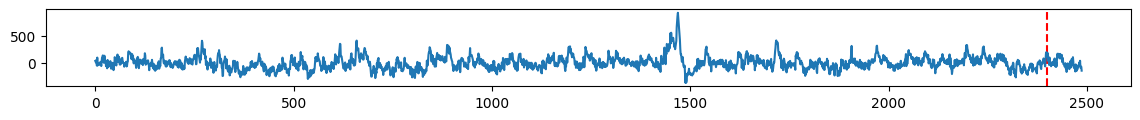

In [32]:
plt.figure(figsize=(14,1))

plt.axvline(x=2400, color='r', linestyle='--')

plt.plot(corrected_video[:,150,150])


In [219]:
epoched_recording = epoch_trials(corrected_video, onset_frames)

In [220]:
baseline_adjusted = baseline_adjust_pixels(epoched_recording)

In [221]:
frequency_formatted = format_trials(baseline_adjusted,conditions)

In [222]:
zscore_dict = convert_to_zscore(frequency_formatted,conditions)

In [223]:
median_zscore_dict = zscore_and_median(frequency_formatted,conditions)

In [19]:
with open(BASE_PATH + 'zscore_dict.pkl','rb') as f:
    zscore_dict = pickle.load(f)

In [224]:
# # save the recording information 
# with open(BASE_PATH+"zscore_dict.pkl",'wb') as f:
#         pickle.dump(zscore_dict,f)

In [20]:
median_zscore = dict.fromkeys(np.unique(conditions[:,0]))

for freq in zscore_dict:

    ave_zscore_array = np.empty([len(zscore_dict[freq]),256,256])
    median_zscore_array = np.empty([1,256,256])
    median_zscore[freq] = {}

    for rep in range(zscore_dict[freq].shape[0]):
        for i in range(zscore_dict[freq].shape[2]):
            for j in range(zscore_dict[freq].shape[3]):
                ave_zscore_array[rep-1,i,j] = np.mean(zscore_dict[freq][rep-1,START:STOP,i,j])
    
     #  iterate through the mean values for each pixel, and find the median value across all trials for that pixel. 
    for i in range(len(ave_zscore_array[0,:,0])):
        for j in range(len(ave_zscore_array[0,0,:])):
            median_zscore_array[:,i,j] = np.median(ave_zscore_array[:,i,j])

    median_zscore[freq] = median_zscore_array
    


In [21]:
# Fits a Median filter to each frame in the recording.  
def fit_median_filter(video,size):
        for frame in range(len(video)):
                video[frame,:,:] = median_filter(video[frame,:,:],size=size)

        return video

In [22]:
# # Normalize the individual frequency so that they are z-scored relative to all of the pixels for that frequency. 
# # This irons out potential bias in the map from the entire cortex being more responsive to particular frequency ranges. 
for key,value in median_zscore.items():
    median_zscore[key] = scipy.stats.zscore((np.squeeze(value)),axis=None)

In [23]:
thresholded_dict = threshold_responses(median_zscore)

In [24]:
# Returns a pixels_y x pixels_x array where each pixel contains a value (0-11), corresponding to the frequency
# with highest z-score response.  If no responses were above threshold, displays 'nan' (shows up as white on plot).
best_freq = get_best_frequency(thresholded_dict)

(12, 256, 256)


In [25]:
best_frequency = median_filter(best_freq,size=3)

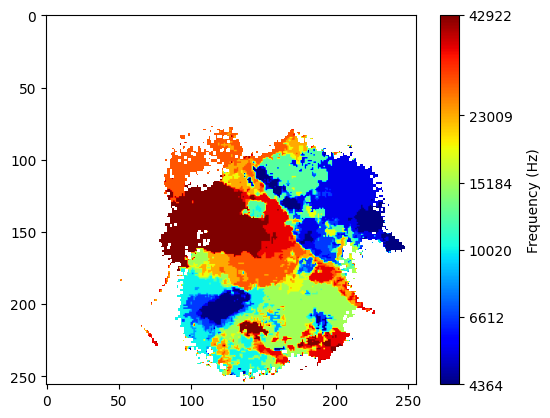

In [26]:
# Plots the tonotopic map of best frequency values. 
plot = plot_tonotopic_map(best_frequency)

In [230]:
#   # save the recording information 
# with open(BASE_PATH+"median_zscore_dict.pkl",'wb') as f:
#     pickle.dump(median_zscore_dict,f)

In [231]:
''' Widefield Analysis Notes:

Take median z-score dict as input.




SyntaxError: EOF while scanning triple-quoted string literal (3354151680.py, line 5)

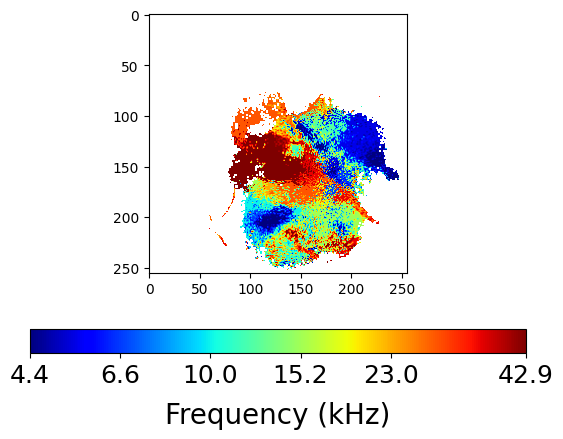

In [30]:
plt.figure()
data = np.squeeze(best_freq)
cax = plt.imshow(data,cmap=cm.jet)
cbar = plt.colorbar(cax, ticks=[0, 2, 4, 6, 8, 11],orientation='horizontal')
cbar.ax.set_xticklabels(['4.4', '6.6', '10.0', '15.2', '23.0', '42.9'],fontsize=18)  # vertically oriented colorbar
cbar.ax.set_xlabel("Frequency (kHz)",labelpad=10,fontsize=20)
plt.show()